*-------------------------------------------------------------------------------------------------*

**Hands-On Machine Learning with Scikit-Learn & TensorFlow**

**Chapter-07 - Ensamble Learning and Random Forests**

**Date : 08-April-2020**

*---------------------------------------------------------------------------------------------------*

**_Content :_**

* Bootstrap

# Ensemble Learning
A group of predictors for a single problem is called ensemble and the technique is called Ensemble Learning. Predictors can be of very different machine learning algorithm or same algorithm. Once you have built a few good predictors, you can combine them into a single better predictor using aggregating, voting etc.

Ensemble methods are among most powerful algorithms, in fact, the winning solutions in ML competitions involve Ensamble methods.

Popular Ensamble Methods : 
* **Voting Classifeirs:** An Ensamble of different ML algorithm predictors on whole Training set
* **Bagging and Pasting and others:** An Ensamble of same ML algorithm predictors
    * **Bagging:** Each predictor is trained on different random (with replacement) subset of training set.
    * **Pasting:** Bagging but without replacement.
    * **Random Patches:** Sampling of instances (with replacement) + Also supports sampling of features.
    * **Random Subspaces:** Sampling of features
* Boosting 
* Stacking


### Lets take a classification problem

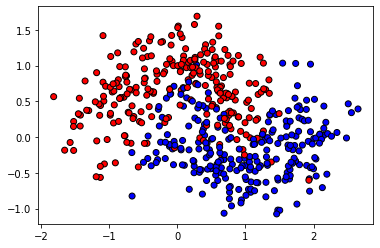

In [113]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm = plt.cm.RdBu

# Function to plot decision boundry, restricted to 2-d plots ie 2 features
def plot_decision_boundry(model,X):
    x1, x2 = np.meshgrid(np.arange(X[:,0].min() -.5, X[:,0].max() +.5 , 0.05),
                         np.arange(X[:,1].min() -.5, X[:,1].max() +.5,  0.05))
    y_plot_pred_probs = model.predict_proba(np.c_[x1.ravel(), x2.ravel()])[:,1]

    plt.contourf(x1,
                 x2,
                 y_plot_pred_probs.reshape(x1.shape), cmap=cm, alpha=.7)
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')

# Lets make a polynomial classifier for non-linear classification problem
from sklearn.datasets import make_moons
# Generating the data
# Training Set
X,y = make_moons(n_samples = 500, noise =0.3)
# Test Set
X_test,y_test = make_moons(n_samples = 1000, noise =.4)

plt.scatter(X[:,0],X[:,1],c=y,cmap=cm_bright,
            edgecolor='k')
plt.show()


## Voting Classifiers
Suppose you have trained a few classifiers (ie Logistic Reg, SVM, Random Forest, KNN etc) on a training set, each one achieving about 80% accuracy. 

* **Hard Voting Classifier**: A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class which gets most votes.
* **Soft Voting Classifier**: If all the classifiers are able to estimate class probabilites (or probably same scale scores). Then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifers.

Ensamble Methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very differnt algorithms. This increases the chances that they will make very different type of errors, improving the ensemble's accuracy.


In [114]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score  

from sklearn.tree  import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier

# Logistic Regression Predictor
logit_clf = Pipeline([('poly',PolynomialFeatures(degree=3, include_bias=False)),
                      ('scaler', StandardScaler()),
                      ('logit_clf_s', LogisticRegression(C=10,max_iter=1000))])
print('Logistic Regression CV Accuracy', cross_val_score(logit_clf, X, y, cv=10, scoring='accuracy').mean())

# SVM classifier
svm_clf = SVC(kernel='rbf',C=10,gamma=2, probability=True)
print('SVM CV Accuracy',cross_val_score(svm_clf, X, y, cv=10, scoring='accuracy').mean())

# Random Forest 
rnd_clf = RandomForestClassifier(n_estimators = 100, oob_score=True, random_state=30)
rnd_clf.fit(X,y)
print('Random Forest CV Accuracy',rnd_clf.oob_score_) 
# What happens if we use all the above classifiers as an Ensemble
# Hard : Majority Votes
voting_clf = VotingClassifier( estimators = [('logit_clf', logit_clf)
                                            ,('svm_clf', svm_clf)
                                            #,('rnd_clf', rnd_clf)
                                            ], voting='hard')

print('Voting Hard CV Accuracy',cross_val_score(voting_clf, X, y, cv=10, scoring='accuracy').mean())

# Soft : Arg Max Average Probability
voting_clf = VotingClassifier( estimators = [('logit_clf', logit_clf)
                                            ,('svm_clf', svm_clf)
                                            #,('rnd_clf', rnd_clf)
                                            ], voting='soft')

print('Voting Soft CV Accuracy',cross_val_score(voting_clf, X, y, cv=10, scoring='accuracy').mean())


# As you see there is improvement for the ensemble thought doesnt seem significant. Maybe because the 
# individual predictors are well enough to predict the data with low variance. so not much for the ensamble 
# technique to improve. 
# Ensamble methods tend to do better when there are high-variance models.


Logistic Regression CV Accuracy 0.89
SVM CV Accuracy 0.9
Random Forest CV Accuracy 0.88
Voting Hard CV Accuracy 0.892
Voting Soft CV Accuracy 0.9039999999999999


#### The Bootstrap: An important fundamental concept for Bagging
The bootstrap is a widely applicable and extremely powerful statistical tool  that can be used to quantify the uncertainty associated with a given esti-mator or statistical learning method.

As a simple example, the bootstrap can be used to estimate the standard errors of the coefficients from a linear
regression fit. Though it is not useful here as statistical software such as R outputs such standard errors automatically.

However, the power of the bootstrap lies in the fact that it can be easily applied to a wide range of statistical learning methods, including some for which a measure of variability is otherwise difficult to obtain and is not automatically output by statistical software.

## Bagging (Bootstrap Aggregation) And Pasting

**Same training algorithm for every predictor trained on bootstraped sample of training instances i.e. different random (with replacement) subsets of training set.** An individual predictor will have high bias when trained on a subset v/s the whole training set. But aggregating the results of these individual predictors reduces overall both bias and variance and generalizes well.

** i.e. , The decision tree prone to overfit and hence suffers from high variance but if you trained multiple DTs on different training samples and aggregate the results it would overall reduce the variance.

**Bagging is used to reduce the variance of a statistical learning methods** : 
Recall that given a set of n independent observations Z1, . . . , Zn, each with variance σ^2, the variance of the sampling mean Z̄ of the observations is given by (σ^2)/n. In other words, averaging a set of observations reduces variance. Hence a natural way to reduce the variance and hence increase the prediction accuracy of a statistical learning method is to take many training sets from the population, build a separate prediction model using each training set, and average the resulting predictions.

Of course, this is not practical because we generally do not have access to population or multiple training sets. Instead, we can bootstrap, by taking repeated samples from the (single) training data set. In this approach we generate B different bootstrapped training data sets. 


**As you see in below experiment**
* DecisionTree with restriction is overfiting the training data and hence low CV and Test accuracy.
* Bagging/Pasting is generalizing data better than a single Decision Tree.
* Bagging often results in better model than pasting.

**How can bagging/pasting be extended to a classification problem where Y is qualitative?** Possible approach is majority vote or average of probability of class if predictors predict the probability.

**Out of Bag Evaluation**: Because of with replacement technique, some instances may be sampled several times for any given predictor (estimators), while others maynotbe sampled at all. So statisticlly 63% (As training size grows, ratio approaches to 63%), of the training instances are sampled on average for each predictor while 37% that are not sampled for training are called out of bag (oob) instances. *Note that they are not the same 37% for all predictors.*

Since a predictor (estimator) never sees the oob instances during training. It can be evaluated on these instances, without the need of seperate validation set. You can evaluate the ensemble itself by averaging out the oob evaluation of each predictor. But for oob evaluation, we need sufficient number of predictors from which aggregating the predictions otherwise it will throw an warning.

In Scikit-Learn, just set oob_score = True.

### Random Subspaces and Random Patches for Bagging

Bagging also supports sampling of features, thus each predictor will be trained on a random subset of the input features. It makes the predictors more diverse, trading a bit more bias for a lower variance.

This technique is helpful when you are dealing with high-dimensional inputs.

Sampling both instances and features is called **Random Patches** method.

Sampling only features and using all instances is called **Random Subspaces** method. parmas(bootstrap = False, max_samples = 1.0, bootstrap_features = True, max_features less than 1.0)

Decision Tree CV Accuracy 0.842
Decision Tree Test Accuracy 0.815


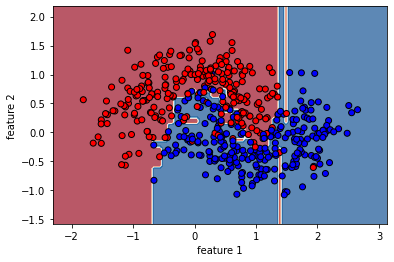

Bagging CV Accuracy 0.876
Bagging Test Accuracy 0.821


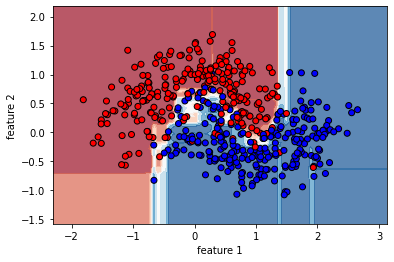

Bagging CV Accuracy 0.85
Bagging Test Accuracy 0.816


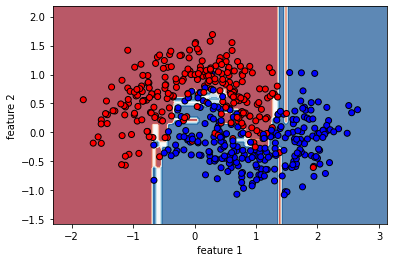

In [122]:
from sklearn.ensemble import BaggingClassifier

# Logistic Regression Predictor
tree_clf = DecisionTreeClassifier(random_state=30) # No Regularizatio, fits until training set if classified correctly. hence have
                                    # High Variance
print('Decision Tree CV Accuracy', cross_val_score(tree_clf, X, y, cv=4, scoring='accuracy').mean())
tree_clf.fit(X,y)
print('Decision Tree Test Accuracy', accuracy_score(tree_clf.predict(X_test),y_test))
plot_decision_boundry(tree_clf,X)
plt.scatter(X[:,0],X[:,1],c=y,cmap=cm_bright,
            edgecolor='k')
plt.show()

# Bagging  
rnd_clf = BaggingClassifier(DecisionTreeClassifier(), bootstrap = True,  random_state=30, oob_score = True, n_jobs=-1,
                            n_estimators = 500, max_samples = 1.0)
#print('Bagging oob Accuracy',rnd_clf.oob_score_)
print('Bagging CV Accuracy', cross_val_score(rnd_clf, X, y, cv=4, scoring='accuracy').mean())

rnd_clf.fit(X,y)
print('Bagging Test Accuracy', accuracy_score(rnd_clf.predict(X_test),y_test))
plot_decision_boundry(rnd_clf,X)
plt.scatter(X[:,0],X[:,1],c=y,cmap=cm_bright,
            edgecolor='k')
plt.show()

# Pasting, just do  bootstrap = False, oob is only availabl for bootstrap=True
rnd_clf = BaggingClassifier(DecisionTreeClassifier(), bootstrap = False,  random_state=30, n_jobs=-1,
                            n_estimators = 500, max_samples = 1.0) # 1.0 means full training set (though with replacement so 63% of data will be used only)
#print('Baggin oob Accuracy',rnd_clf.oob_score_) 
print('Bagging CV Accuracy', cross_val_score(rnd_clf, X, y, cv=4, scoring='accuracy').mean())

rnd_clf.fit(X,y)
print('Bagging Test Accuracy', accuracy_score(rnd_clf.predict(X_test),y_test))
plot_decision_boundry(rnd_clf,X)
plt.scatter(X[:,0],X[:,1],c=y,cmap=cm_bright,
            edgecolor='k')
plt.show()

# More data you give to high variance ML algo, less sensitive it gets.
# More noise in test data, better bagging algorithm will perform

## Random Forests
It is an ensamble of Decision Trees.

*Instances Sampling*: 

Generally trained via bagging (or sometime pasting) methods. Typically max_samples set to the size of the training set.

*Feature Sampling*: (at every node splittng instead for a random subset of features for every predictor)

It also samples features but not like Random Patches where each predictor is trained on random subset of features instead it uses random subset of features when splitting a node. It further boosts the diversity among trees, and trades a little bit more bias for lower variance. 

These instances and feature sampling is handled by bootstrap, max_samples, max_featuress hyperparameter.

Instead of using *BaggingClassifier* and passing *DecisionTreeClassifier()*, we can instaed use *RandomForestClassifier* which is more optimized.

### Feature Importance
Random Forest  also measure the relative importance of each feature, by looking at how much the tree nodes that  use that features reduce impurity on average (across all trees in the forest). More Precisely it is weighted average where each node's weight is the associated n_samples.

## Extra Trees

It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible threshold. A forest of such extremely random trees is called **Extremely Randomized Trees** ensemble. Once again this technique trades more bias for lower variance.

It also make Extra-Trees much faster to train than regualar random forests, because finding the best possible threshold for each feature at every node is one of the most time consuming tasks of growing a tree.

### Random Forests or Extra-Trees ?
It is hard to tell which (Random Forests or Extra-Trees) will perform better. Generally the only way to know is to tr both and compare them using cross-validation (tuning the parameters using grid search).

As you see there is not much performance difference for both RandomForestClassifiers and ExtraTreesClassifiers.

Random Forest CV Accuracy 0.88
Random Forest OOB Accuracy 0.874
Random Forest Test Accuracy 0.831


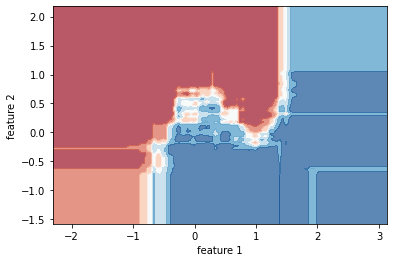

Extra Trees CV Accuracy 0.88
Extra Trees OOB Accuracy 0.886
Extra Trees Test Accuracy 0.836


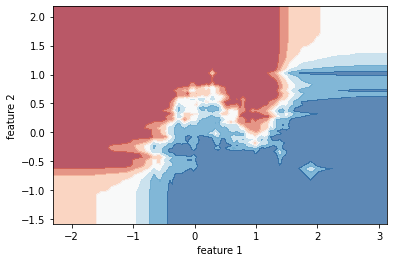

In [128]:
from sklearn.ensemble import ExtraTreesClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, oob_score=True, n_jobs =-1, random_state=30, max_samples=0.99) 
                                # max_features =sqrt(n_features) default value
rnd_clf.fit(X,y)
print('Random Forest CV Accuracy', cross_val_score(rnd_clf, X, y, cv=4, scoring='accuracy').mean())
print('Random Forest OOB Accuracy',rnd_clf.oob_score_) 
print('Random Forest Test Accuracy', accuracy_score(rnd_clf.predict(X_test),y_test))
plot_decision_boundry(rnd_clf,X)
plt.show()

rnd_clf = ExtraTreesClassifier(bootstrap=True, n_estimators = 500, oob_score=True, n_jobs =-1, random_state=30, max_samples=0.99) 
                                # max_features =sqrt(n_features) default value
rnd_clf.fit(X,y)
print('Extra Trees CV Accuracy', cross_val_score(rnd_clf, X, y, cv=4, scoring='accuracy').mean())
print('Extra Trees OOB Accuracy',rnd_clf.oob_score_) 
print('Extra Trees Test Accuracy', accuracy_score(rnd_clf.predict(X_test),y_test))
plot_decision_boundry(rnd_clf,X)
plt.show()

## Boosting
Any Ensemble Method that combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

Most Popular Boosting Methods are:
* AdaBoost
* Gradient Boosting

### AdaBoost: 
One way for a new predictor to correct its predecessor predictor is to pay bit more attention to the training instances that the predecessor underfitted.

For example, It starts with training a base classifier (such as Decision Tree etc) and uses it to make prediction on the training set. The algortihm then increase weight of misclassified training instances. Then it trains a second classifier using the updated weight and again make predictions on the training set, update weights and so on.

To make preictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictors weights calculated above. 

Scikit-Learn uses a multiclass version of AdaBoost called SAMME (which stands for Stagewise Additive Modelling using a Multiclass Exponential loss Function). When there are just two classes, SAMME is equivalent too AdaBoost.

Cons AdaBoost:
Since its a sequential learning techniqu, it cannot be parallalized


AdaBoost CV Accuracy 0.892
AdaBoost Test Accuracy 0.843


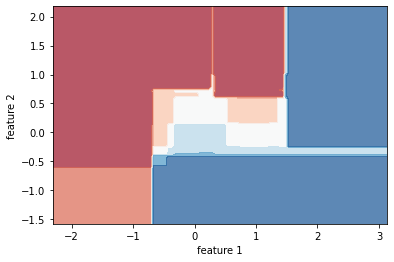

In [162]:
from sklearn.ensemble import AdaBoostClassifier

#Sometimes, AdaBoost uses short stumps (Decision Trees with a single split), but Scikit learn provides us to increase the tree depth.
ada_clf = AdaBoostClassifier(DecisionTreeClassifier( max_depth=1), # Tree Stumps
                             n_estimators = 10, algorithm = 'SAMME.R',learning_rate = 0.5, random_state=30) 
                                # max_features =sqrt(n_features) default value
ada_clf.fit(X,y)
print('AdaBoost CV Accuracy', cross_val_score(ada_clf, X, y, cv=4, scoring='accuracy').mean())
print('AdaBoost Test Accuracy', accuracy_score(ada_clf.predict(X_test),y_test))
plot_decision_boundry(ada_clf,X)
plt.show()


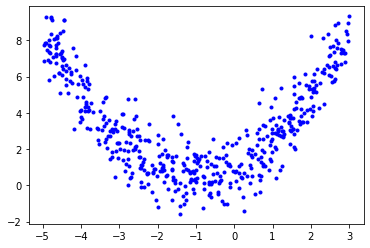

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_quadratic_data(number_of_instances):
    X = 8* np.random.rand(number_of_instances,1) - 5
    y = 0.5 * X**2  + X + 1 +  np.random.randn(number_of_instances,1) #np.random.uniform(low = -1, high = 1,size = (m,1)
    return(X,y.ravel())

X,y = generate_quadratic_data(500)
X_test,y_test = generate_quadratic_data(500)

X_plot = np.linspace(X[:,0].min()-.05,X[:,0].max()+.05,100).reshape(-1,1)

plt.plot(X_test,y_test, 'b.')
plt.show()

### Gradient Boosting:
Just like AdaBoost,it works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However instead of tweaking the instance weights instead at every iteration of adding the predictor, this method tries to fit the new predicotr to the residual errors made by the predictor.

#### Gradient Boosting Regression Tree (GBRT)

Loss Function : error = y-y' (gradient for least square 'ls' loss setting, there are other loss function like  aboslute deviation, huber etc) 

So at every step, we are calculating gradient (error) and then creating tree which can be regularized with

Regulariation : 
* Number of trees
* Shrinkage
* Stochastic Gradient Boosting: fitting trees on subsamples
* Penalizing Complexity of Trees.

**Utility to learn the model, asses the performance, and plot the model**

In [7]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate
scoring =  make_scorer(mean_squared_error)
   
# Utility to learn the model, asses and plot the leanred model.
def trainRegressionTree(model, X, y, X_plot):
    #print('Cross validation Accuracy : ',
    #      cross_val_score(model, X, y, cv=4, scoring='neg_root_mean_squared_error').mean() * -1)
    
    cv_results = cross_validate(model, X, y, cv=4, 
                scoring=scoring,return_train_score= True)
    print('CV Train MSE',cv_results['train_score'].mean())
    print('CV Test MSE',cv_results['test_score'].mean())
    
    model.fit(X,y)
    
    plt.plot(X,y, 'b.',alpha=.2)
    plt.plot(X_plot, model.predict(X_plot), 'g-', linewidth=4)
    plt.show()
    return(model)


**Lets see whats happening behind the scenes of GBRT**

Explained for least squared loss setting. 

Learning GBRT using GradientBoostingRegressor function : 
CV Train MSE 1.2232383073198854
CV Test MSE 1.5499193871013466


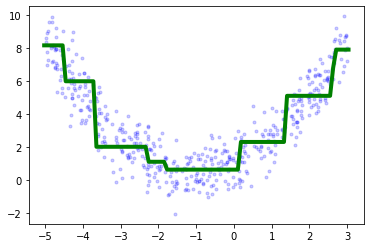

Base Tree Model on y
CV Train MSE 1.9302176853026716
CV Test MSE 2.16096543943115


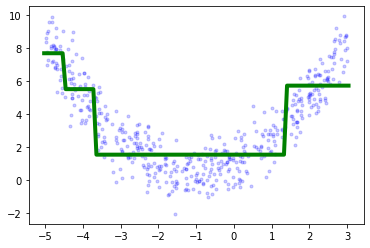

Second Tree Model on "error = y - y_pred"
CV Train MSE 1.4860039554427003
CV Test MSE 1.577211883138894


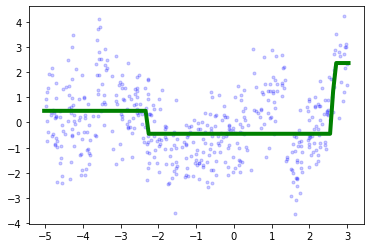

Second Tree Model on "error2 = error - error_pred"
CV Train MSE 1.2762456722612672
CV Test MSE 1.3937608901225145


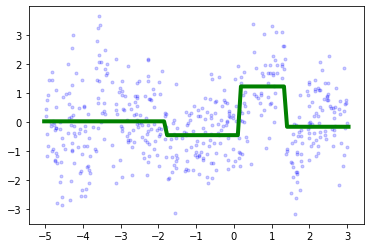

Final Gradient Boosting Regression Tree Model, As you see it is similar to the GBRT learned using GradientBoostingRegressor


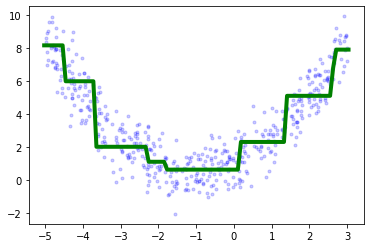

In [14]:
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor

print('Learning GBRT using GradientBoostingRegressor function : ')
gbrt = GradientBoostingRegressor(loss = 'ls',max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt = trainRegressionTree(gbrt, X, y, X_plot)



# Lets see how the above GBRT is working behind the scenes using Decision Trees without
# Learn a base sequential tree on 'y' and then sequential tree on corresponing remaining errors.

tree_reg = DecisionTreeRegressor(max_depth=2)#, min_samples_split=40 ) 
    

print('Base Tree Model on y')
tree_reg1 = trainRegressionTree(tree_reg, X, y, X_plot)


print('Second Tree Model on "error = y - y_pred"')
error1 =  y - tree_reg1.predict(X)
tree_reg2 = trainRegressionTree(clone(tree_reg), X, error1, X_plot)

print('Second Tree Model on "error2 = error - error_pred"')
error2 =  error1 - tree_reg2.predict(X)
tree_reg3 = trainRegressionTree(clone(tree_reg), X, error2, X_plot)


y_plot_pred_final = sum(tree.predict(X_plot) for tree in (tree_reg1,tree_reg2,tree_reg3))
print('Final Gradient Boosting Regression Tree Model, As you see it is similar to the GBRT learned using GradientBoostingRegressor')
plt.plot(X,y, 'b.',alpha=.2)
plt.plot(X_plot,y_plot_pred_final, 'g-', linewidth=4)
plt.show()


#  

The learning hyperparameter scales the contributution of each tree. If you set it to a low value ie 0.1, you will need more treed in the ensmble to generalize better. This is a regularization technique caled Shrinkage.


-----------------------Gradient Boosting Regression Trees--------------------------------------
CV Train MSE 0.8140209057392667
CV Test MSE 1.067556059095405


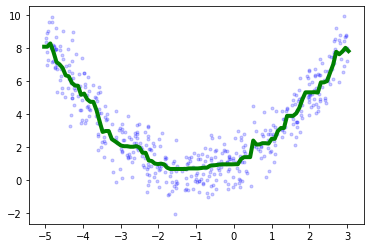

--> MSE of the model on Testset:  1.0945358423246487


In [27]:

print()
print('-----------------------Gradient Boosting Regression Trees--------------------------------------')

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.05, criterion = 'mse',
                                 subsample = .7)
gbrt = trainRegressionTree(gbrt, X, y, X_plot )
y_test_pred= gbrt.predict(X_test)  # Test data

print('--> MSE of the model on Testset: ',mean_squared_error(y_test,y_test_pred))


**Early Stopping** : In order to find the optimal number of trees, you can use early stopping. A simple way to implement this is to use the staged predict() method: It returns an iterator over the predictions made by the ensemble at each stage of training(with one tree, two tree etc.). 

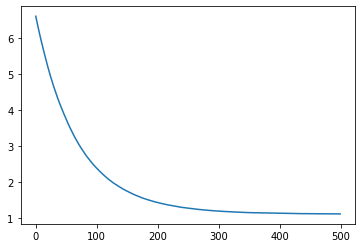

Optimal Number of Trees and Test error 496 1.1089326492684999
CV Train MSE 0.8953028866544108
CV Test MSE 1.1422211914783182


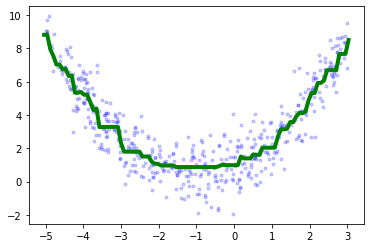

In [369]:
lrn_rate = 0.01
mx_d = 2
gbrt = GradientBoostingRegressor(n_estimators=500, max_depth=mx_d, learning_rate= lrn_rate)
gbrt.fit(X,y)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]

plt.plot(errors)
plt.show()

best_n_estimator = np.argmin(errors) + 1
print('Optimal Number of Trees and Test error',best_n_estimator, np.min(errors))

gbrt = GradientBoostingRegressor( n_estimators=best_n_estimator,max_depth=mx_d, learning_rate= lrn_rate)
gbrt = trainRegressionTree(gbrt, X, y, X_plot )


**Linear Model vs Regresion Tree vs Random Forest vs Gradient Boosting Regression Tree**

As you see,
* Linear Model (qudratic feature) is the best model here as the True Function that generates the data and our estimated function closely matches. 
* Decision Tree has very wiggly boundry which shows its sensetiveness to training set and hence doesnt provide an optimal model
* GBRT here does a decent job and tries to mimick the true funcion, still it has wiggly boundry but a far better choice than a single tree.


----------------------------Linear Regression------------------------------------------------
CV Train MSE 0.9903713241389712
CV Test MSE 1.008473914513699


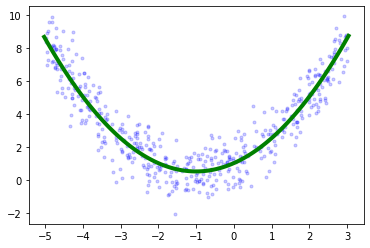

--> MSE of the model on Testset:  1.0516633564597926

----------------------------Regression Tree------------------------------------------------
CV Train MSE 0.7838546467185897
CV Test MSE 1.2695438451617787


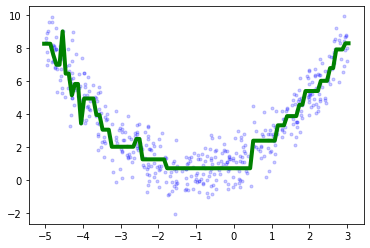

--> MSE of the model on Testset:  1.1865205057810058

----------------------------Random Forest------------------------------------------------
CV Train MSE 0.5338857028246072
CV Test MSE 1.1966933984658799


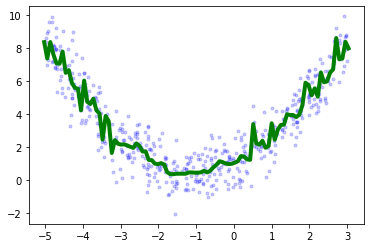

--> MSE of the model on Testset:  1.2501556836164736

-----------------------Gradient Boosting Regression Trees--------------------------------------
CV Train MSE 0.7709849448882028
CV Test MSE 1.0935104624104581


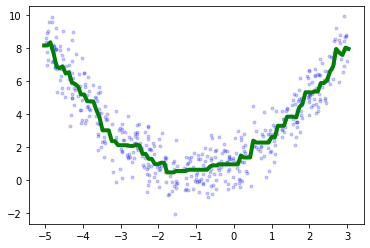

--> MSE of the model on Testset:  1.1127680998007576


In [20]:

# Training the model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


print()
print('----------------------------Linear Regression------------------------------------------------')
lin_model  = Pipeline([
    ("poly_features", PolynomialFeatures( degree=2, include_bias = False)),
    ("scaler",StandardScaler()),
    ("lin_reg", LinearRegression()),
])
lin_model = trainRegressionTree(lin_model, X, y, X_plot )
y_test_pred= lin_model.predict(X_test)  # Test data
print('--> MSE of the model on Testset: ',mean_squared_error(y_test,y_test_pred))

print()
print('----------------------------Regression Tree------------------------------------------------')

tree_reg = DecisionTreeRegressor(criterion = 'mse', max_depth=5)#, min_samples_split=40 ) 
tree_reg = trainRegressionTree(tree_reg, X, y, X_plot )
y_test_pred= tree_reg.predict(X_test)  # Test data
print('--> MSE of the model on Testset: ',mean_squared_error(y_test,y_test_pred))



print()
print('----------------------------Random Forest------------------------------------------------')
rnd_reg = RandomForestRegressor(n_estimators = 50, max_depth=7, n_jobs =-1, random_state=30, max_samples=0.9) 
tree_reg = trainRegressionTree(rnd_reg, X, y, X_plot )
y_test_pred= rnd_reg.predict(X_test)  # Test data
print('--> MSE of the model on Testset: ',mean_squared_error(y_test,y_test_pred))


print()
print('-----------------------Gradient Boosting Regression Trees--------------------------------------')

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.07)
gbrt = trainRegressionTree(gbrt, X, y, X_plot )
y_test_pred= gbrt.predict(X_test)  # Test data

print('--> MSE of the model on Testset: ',mean_squared_error(y_test,y_test_pred))
